In [ ]:
import kagglehub
import os

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Dataset directory contents:")
print(os.listdir(path))

Dataset directory contents:
['Training', 'Testing']


In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

In [3]:
# List contents inside Training and Testing folders
training_path = os.path.join(path, 'Training')
testing_path = os.path.join(path, 'Testing')

print("\n📂 Contents of Training:")
print(os.listdir(training_path))

print("\n📂 Contents of Testing:")
print(os.listdir(testing_path))



📂 Contents of Training:
['pituitary', 'notumor', 'meningioma', 'glioma']

📂 Contents of Testing:
['pituitary', 'notumor', 'meningioma', 'glioma']


In [4]:
import tensorflow as tf
from tensorflow.keras import models,layers

training_dir = os.path.join(path, "Training") # Supervised learning setup: data is organized into labeled folders


IMAGE_SIZE = 224      
BATCH_SIZE = 32       

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE), # Feature engineering: resize input to fixed dimensions
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print("Class names:", class_names)

#

2025-07-16 09:05:14.872041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752656715.065920      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752656715.120012      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5712 files belonging to 4 classes.


I0000 00:00:1752656731.979928      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752656731.980657      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [5]:
testing_dir = os.path.join(path, "Testing")
# Load the dataset from the Training directory
dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    testing_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Check dataset structure
class_names = dataset_test.class_names
print("Class names:", class_names)

Found 1311 files belonging to 4 classes.
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
for image_batch,labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())

(32, 224, 224, 3)
[3 3 1 1 1 0 0 3 1 3 2 1 3 2 2 1 1 2 1 0 2 2 3 3 2 3 1 3 1 1 0 3]


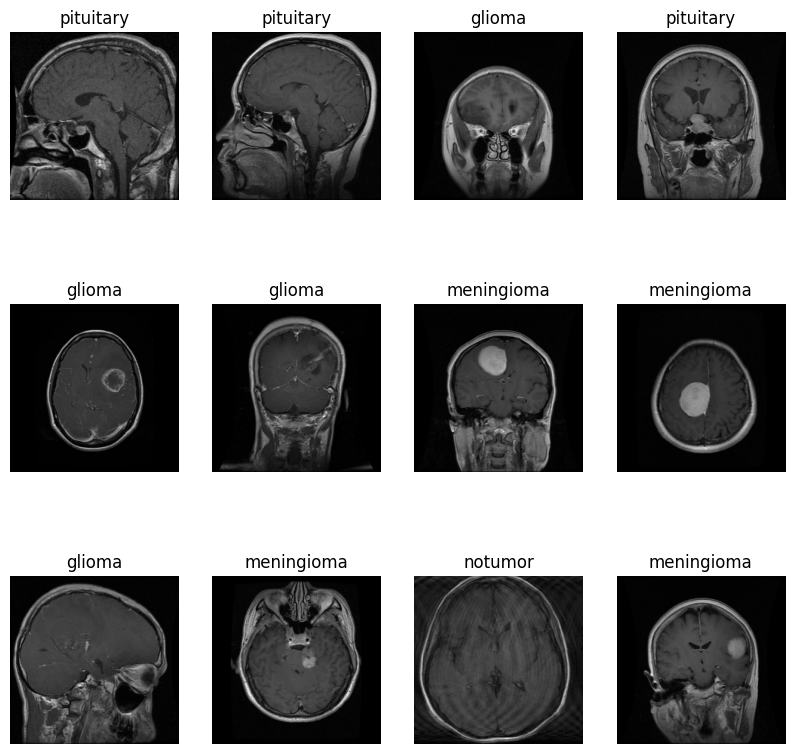

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1) #exploratory data analysis
    plt.imshow(image_batch[i].numpy().astype("uint8")) # data visualization 
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

In [8]:
len(dataset)

179

In [9]:
len(dataset_test)

41

In [10]:
def get_train_val_split(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000): # randomization shuffle=true->reduce bias by mixing up data
    assert (train_split + val_split) == 1, "Train + val splits must sum to 1"

    ds_size = tf.data.experimental.cardinality(ds).numpy()

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size)

    return train_ds, val_ds


In [11]:
train_ds, val_ds= get_train_val_split(dataset)


In [12]:
len(train_ds)

143

In [13]:
len(val_ds)

36

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = dataset_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#Data caching	Increases training speed by reducing I/O overhead


In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
#data augmentation Rotates images randomly to increase robustness against orientation changes.

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 52, 52, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 26, 26, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 24, 24, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 12, 12, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 10, 10, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 5, 5, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 3, 3, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 1, 1, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,524 (670.02 KB)

 Trainable params: 171,524 (670.02 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


I0000 00:00:1752656752.693181     103 service.cc:148] XLA service 0x7a19ac10c580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752656752.694025     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752656752.694045     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752656753.080905     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/143 ━━━━━━━━━━━━━━━━━━━━ 49:32 21s/step - accuracy: 0.2500 - loss: 1.3931

I0000 00:00:1752656757.878666     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 314ms/step - accuracy: 0.3709 - loss: 1.2562 - val_accuracy: 0.7130 - val_loss: 0.7531
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 233ms/step - accuracy: 0.6776 - loss: 0.8021 - val_accuracy: 0.7482 - val_loss: 0.6799
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 232ms/step - accuracy: 0.7509 - loss: 0.6469 - val_accuracy: 0.7914 - val_loss: 0.5669
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 232ms/step - accuracy: 0.7608 - loss: 0.6034 - val_accuracy: 0.7421 - val_loss: 0.6836
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 229ms/step - accuracy: 0.7825 - loss: 0.5652 - val_accuracy: 0.8081 - val_loss: 0.5199
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 232ms/step - accuracy: 0.7955 - loss: 0.5137 - val_accuracy: 0.8398 - val_loss: 0.4450
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 235ms/step - accuracy: 0.8197 - loss: 0.4616 - val_accuracy: 0.8565 - val_loss: 0.3649
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 232ms/step - accuracy: 0.8388 - loss: 0.4113 - val

In [22]:
scores = model.evaluate(test_ds)

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9408 - loss: 0.2319


In [23]:
scores

[0.20304757356643677, 0.936689555644989]

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 143}

In [26]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [27]:
type(history.history['loss'])

list

In [28]:
len(history.history['loss'])

50

In [29]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0980608463287354,
 0.7691120505332947,
 0.6497626304626465,
 0.5834614038467407,
 0.5518937706947327]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

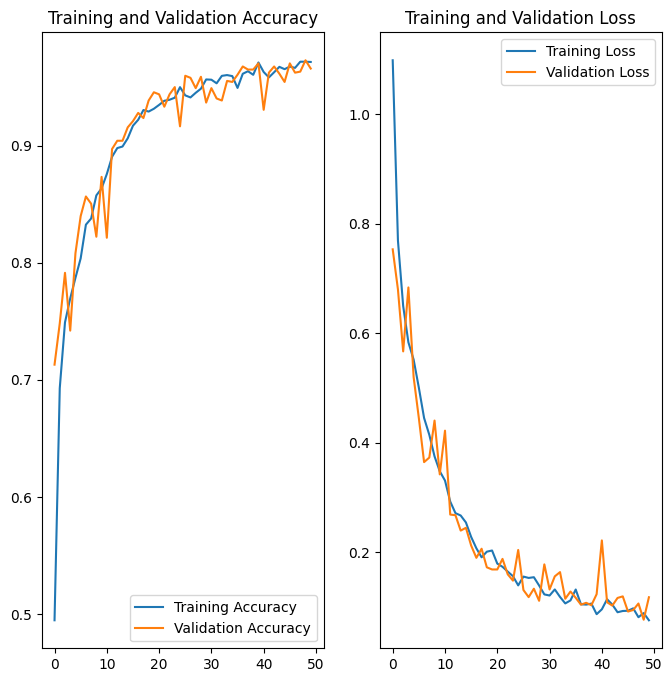

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: notumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
predicted label: notumor


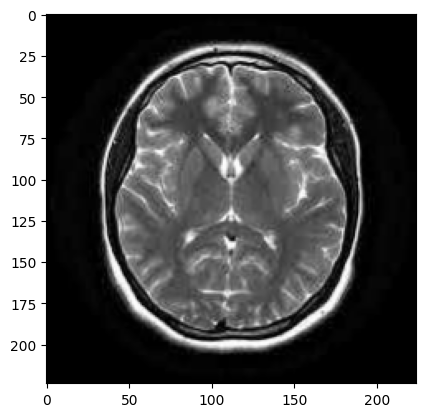

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


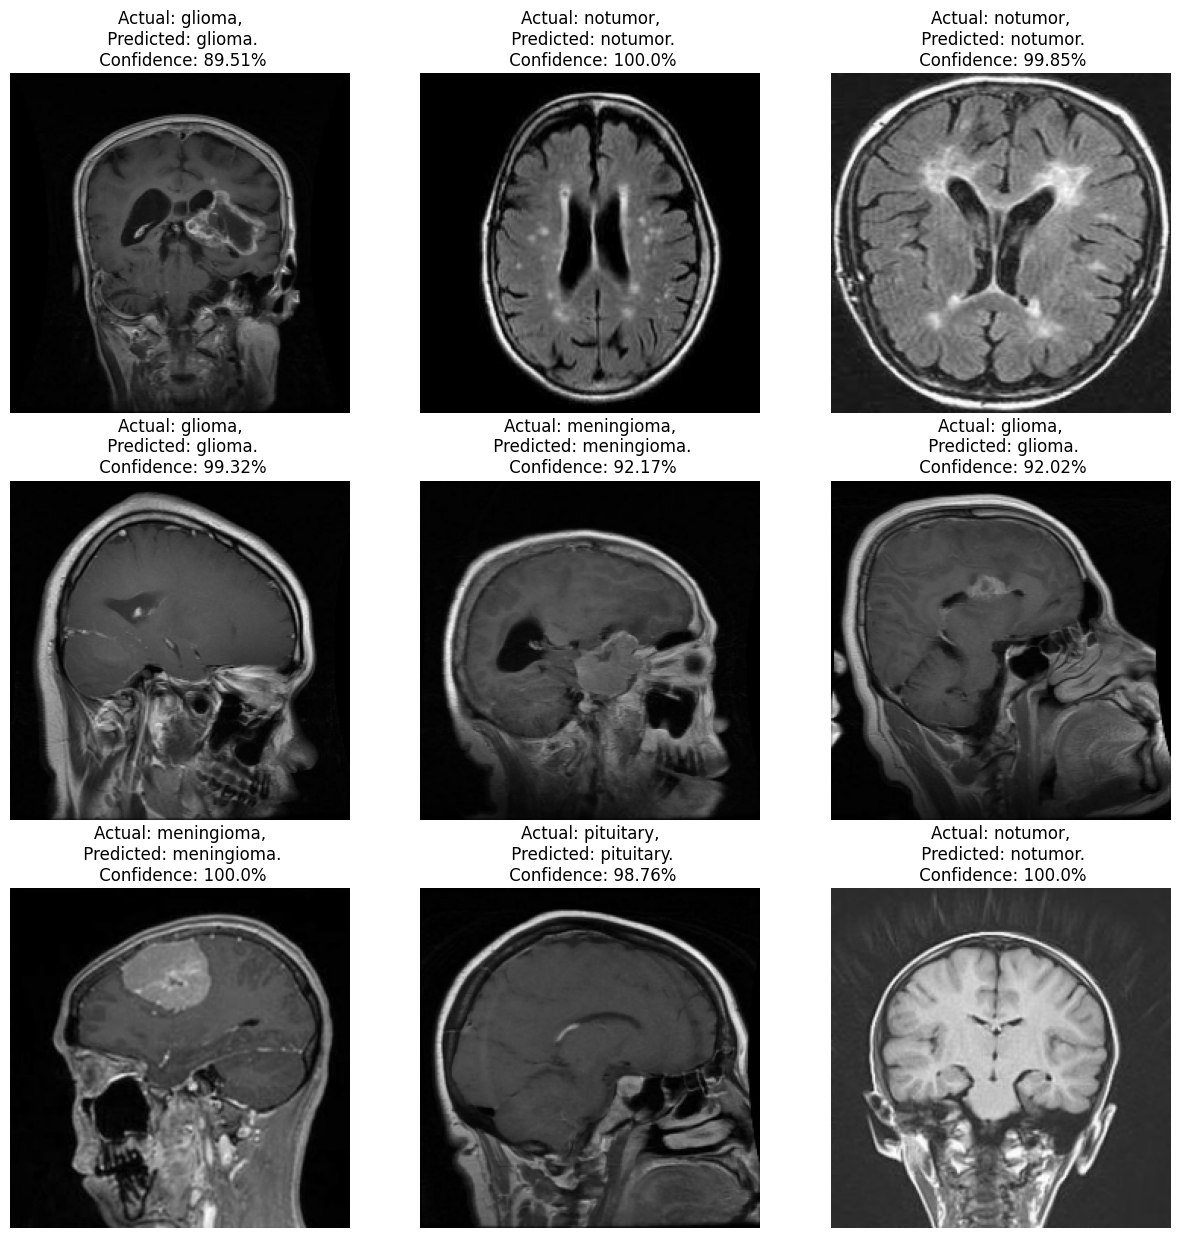

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [37]:
model.save("MRI.keras")

In [38]:
model.save("MRI.keras")

In [39]:
import os
print(os.listdir('/kaggle/working/'))

['MRI.keras', '.virtual_documents', 'potato.keras']
